In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


2 Physical GPUs, 2 Logical GPUs


In [3]:
import os


EPOCHS = 100
BATCH_SIZE = 8
ARCH = "flor"

IMG_SIZE = (128,32, 1)
DATA_ROOT_PATH = "/kaggle/input/htr123/Pyt/data"
IMAGES_PATH = os.path.join(DATA_ROOT_PATH, "images", "data")
IMAGES_PATH

'/kaggle/input/htr123/Pyt/data/images/data'

In [4]:
vocab = None

with open(os.path.join(DATA_ROOT_PATH, "hindi_vocab.txt"),encoding="utf-8") as f:
  vocab = f.readlines()

idx_to_vocab = {i:value.strip() for i, value in enumerate(vocab)}
vocab_to_idx = {value:key for key, value in idx_to_vocab.items()}

In [5]:

train_data = None

with open(os.path.join(DATA_ROOT_PATH, "new_train.txt"), encoding="utf-8") as f:
  train_data = f.readlines()

In [6]:
valid_data = None

with open(os.path.join(DATA_ROOT_PATH, "new_val.txt"), encoding="utf-8") as f:
  valid_data = f.readlines()

In [7]:

test_data = None

with open(os.path.join(DATA_ROOT_PATH, "new_val.txt"), encoding="utf-8") as f:
  test_data = f.readlines()

In [8]:
charl = None

with open( "/kaggle/input/htr123/Pyt/src/charList.txt", encoding="utf-8") as f:
  charl = f.readlines()
charl = charl[0]

# train data labels

# train data generation

In [9]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from PIL import Image, ImageOps


In [10]:

##label generator
def label_g(l):
    label=idx_to_vocab[l]
    z=[]
    for j in range(27):
        z.append(0)
    for k in range(len(label)):
        for r in range(len(charl)):
            if label[k]==charl[r]:
                z[k]=r
    return z   

In [11]:

##label generator
def label_g1(l):
    label=idx_to_vocab[l]
    z=[]
    for k in range(len(label)):
        for r in range(len(charl)):
            if label[k]==charl[r]:
                z.append(r)
                
    return z   

In [12]:
import re
import os
import cv2
import html
import string
import numpy as np


def adjust_to_see(img):
    """Rotate and transpose to image visualize (cv2 method or jupyter notebook)"""

    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D((cX, cY), -90, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    img = cv2.warpAffine(img, M, (nW + 1, nH + 1))
    img = cv2.warpAffine(img.transpose(), M, (nW, nH))

    return img


def augmentation(imgs,
                 rotation_range=0,
                 scale_range=0,
                 height_shift_range=0,
                 width_shift_range=0,
                 dilate_range=1,
                 erode_range=1):
    """Apply variations to a list of images (rotate, width and height shift, scale, erode, dilate)"""

    imgs = imgs.astype(np.float32)
    _, h, w = imgs.shape

    dilate_kernel = np.ones((int(np.random.uniform(1, dilate_range)),), np.uint8)
    erode_kernel = np.ones((int(np.random.uniform(1, erode_range)),), np.uint8)
    height_shift = np.random.uniform(-height_shift_range, height_shift_range)
    rotation = np.random.uniform(-rotation_range, rotation_range)
    scale = np.random.uniform(1 - scale_range, 1)
    width_shift = np.random.uniform(-width_shift_range, width_shift_range)

    trans_map = np.float32([[1, 0, width_shift * w], [0, 1, height_shift * h]])
    rot_map = cv2.getRotationMatrix2D((w // 2, h // 2), rotation, scale)

    trans_map_aff = np.r_[trans_map, [[0, 0, 1]]]
    rot_map_aff = np.r_[rot_map, [[0, 0, 1]]]
    affine_mat = rot_map_aff.dot(trans_map_aff)[:2, :]

    for i in range(len(imgs)):
        imgs[i] = cv2.warpAffine(imgs[i], affine_mat, (w, h), flags=cv2.INTER_NEAREST, borderValue=255)
        imgs[i] = cv2.erode(imgs[i], erode_kernel, iterations=1)
        imgs[i] = cv2.dilate(imgs[i], dilate_kernel, iterations=1)

    return imgs


"""
DeepSpell based text cleaning process.
    Tal Weiss.
    Deep Spelling.
    Medium: https://machinelearnings.co/deep-spelling-9ffef96a24f6#.2c9pu8nlm
    Github: https://github.com/MajorTal/DeepSpell
"""

RE_DASH_FILTER = re.compile(r'[\-\˗\֊\‐\‑\‒\–\—\⁻\₋\−\﹣\－]', re.UNICODE)
RE_APOSTROPHE_FILTER = re.compile(r'&#39;|[ʼ՚＇‘’‛❛❜ߴߵ`‵´ˊˋ{}{}{}{}{}{}{}{}{}]'.format(
    chr(768), chr(769), chr(832), chr(833), chr(2387),
    chr(5151), chr(5152), chr(65344), chr(8242)), re.UNICODE)
RE_RESERVED_CHAR_FILTER = re.compile(r'[¶¤«»]', re.UNICODE)
RE_LEFT_PARENTH_FILTER = re.compile(r'[\(\[\{\⁽\₍\❨\❪\﹙\（]', re.UNICODE)
RE_RIGHT_PARENTH_FILTER = re.compile(r'[\)\]\}\⁾\₎\❩\❫\﹚\）]', re.UNICODE)
RE_BASIC_CLEANER = re.compile(r'[^\w\s{}]'.format(re.escape(string.punctuation)), re.UNICODE)

LEFT_PUNCTUATION_FILTER = """!%&),.:;<=>?@\\]^_`|}~"""
RIGHT_PUNCTUATION_FILTER = """"(/<=>@[\\^_`{|~"""
NORMALIZE_WHITESPACE_REGEX = re.compile(r'[^\S\n]+', re.UNICODE)


def text_standardize(text):
    """Organize/add spaces around punctuation marks"""

    if text is None:
        return ""

    text = html.unescape(text).replace("\\n", "").replace("\\t", "")

    text = RE_RESERVED_CHAR_FILTER.sub("", text)
    text = RE_DASH_FILTER.sub("-", text)
    text = RE_APOSTROPHE_FILTER.sub("'", text)
    text = RE_LEFT_PARENTH_FILTER.sub("(", text)
    text = RE_RIGHT_PARENTH_FILTER.sub(")", text)
    text = RE_BASIC_CLEANER.sub("", text)

    text = text.lstrip(LEFT_PUNCTUATION_FILTER)
    text = text.rstrip(RIGHT_PUNCTUATION_FILTER)
    text = text.translate(str.maketrans({c: f" {c} " for c in string.punctuation}))
    text = NORMALIZE_WHITESPACE_REGEX.sub(" ", text.strip())

    return text


def normalization(imgs):
    """Normalize list of images"""

    imgs = np.asarray(imgs).astype(np.float32)
    _, h, w = imgs.shape

    for i in range(len(imgs)):
        m, s = cv2.meanStdDev(imgs[i])
        imgs[i] = imgs[i] - m[0][0]
        imgs[i] = imgs[i] / s[0][0] if s[0][0] > 0 else imgs[i]

    return np.expand_dims(imgs, axis=-1)


"""
Preprocess metodology based in:
    H. Scheidl, S. Fiel and R. Sablatnig,
    Word Beam Search: A Connectionist Temporal Classification Decoding Algorithm, in
    16th International Conference on Frontiers in Handwriting Recognition, pp. 256-258, 2018.
"""


import cv2
import numpy as np
import matplotlib.pyplot as plt
def preprocess(img, input_size):
    """Make the process with the `input_size` to the scale resize"""

    def imread(path):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        u, i = np.unique(np.array(img).flatten(), return_inverse=True)
        background = int(u[np.argmax(np.bincount(i))])
        # plt.imshow(img)
        return img, background

    if isinstance(img, str):
        img, bg = imread(img)

    if isinstance(img, tuple):
        image, boundbox = img
        img, bg = imread(image)

        for i in range(len(boundbox)):
            if isinstance(boundbox[i], float):
                total = len(img) if i < 2 else len(img[0])
                boundbox[i] = int(total * boundbox[i])
            else:
                boundbox[i] = int(boundbox[i])

        img = np.asarray(img[boundbox[0]:boundbox[1], boundbox[2]:boundbox[3]], dtype=np.uint8)

    wt, ht = input_size[:-1]
    h, w = np.asarray(img).shape
    f = max((h / ht), (w / wt) )

    new_size = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1))

    img = cv2.resize(img, new_size, interpolation=cv2.INTER_AREA)

    target = np.ones([ht, wt], dtype=np.uint8) * bg
    target[0:new_size[1], 0:new_size[0]] = img
    img = target
    # plt.imshow(img)
    return img


In [13]:
s=np.zeros((8, 27))
s

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [14]:
class DataGen(tf.keras.utils.Sequence):
    def __init__(self, data, img_size, batch_size, mode="TRAIN"):
        self.data = data
        self.img_size = img_size
        self.batch_size = batch_size
        self.mode = mode
        self.datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=5, width_shift_range=0.05,
                                                                        height_shift_range=0.05, shear_range=0.05,
                                                                        zoom_range=0.05)

    def __getitem__(self, i):
        start = i * self.batch_size
        end = (i+1) * self.batch_size
        batch_images = np.zeros((self.batch_size, self.img_size[0], self.img_size[1], 1))
        batch_labels = np.zeros((self.batch_size, 27))

        for ii, df_index in enumerate(range(start, end)):
            curr_data = self.data[ii].split()
            curr_img_path = curr_data[0]
          
            curr_label = label_g(int(curr_data[1]))

            curr_img_path = "/".join(curr_img_path.split("/")[2:])
            curr_img_path = os.path.join(IMAGES_PATH, curr_img_path)

            curr_img = preprocess(curr_img_path, self.img_size)
            curr_img = cv2.adaptiveThreshold(curr_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 199, 5)
            curr_img = curr_img[:, :, np.newaxis]  # add new axis for channels

            # Apply data augmentation
            curr_img = self.datagen.random_transform(curr_img)

            batch_images[ii, :, :, 0] = np.transpose(curr_img, (1, 0, 2))[:, :, 0]
            batch_labels[ii,:] = curr_label
                    
        if self.mode == "TRAIN":
          return batch_images, batch_labels
        else:
          return batch_images
        
    def __len__(self):
      return len(self.data) // self.batch_size


In [26]:
train_datagen = DataGen(train_data, IMG_SIZE,128)

In [16]:
test_datagen = DataGen(test_data, IMG_SIZE, 1000
                      )

In [27]:
validation_datagen = DataGen(valid_data, IMG_SIZE, 128)


# model


In [18]:
"""
Gated implementations
    GatedConv2D: Introduce a Conv2D layer (same number of filters) to multiply with its sigmoid activation.
    FullGatedConv2D: Introduce a Conv2D to extract features (linear and sigmoid), making a full gated process.
                     This process will double number of filters to make one convolutional process.
"""

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer, Conv2D, Multiply, Activation

"""
Tensorflow Keras layer implementation of the gated convolution.
    Args:
        kwargs: Conv2D keyword arguments.
    Reference:
        T. Bluche, R. Messina,
        Gated convolutional recurrent neural networks for multilingual handwriting recognition.
        14th IAPR International Conference on Document Analysis andRecognition (ICDAR),
        p. 646–651, 11 2017.
"""


class GatedConv2D(Conv2D):
    """Gated Convolutional Class"""

    def __init__(self, **kwargs):
        super(GatedConv2D, self).__init__(**kwargs)

    def call(self, inputs):
        """Apply gated convolution"""

        output = super(GatedConv2D, self).call(inputs)
        linear = Activation("linear")(inputs)
        sigmoid = Activation("sigmoid")(output)

        return Multiply()([linear, sigmoid])

    def get_config(self):
        """Return the config of the layer"""

        config = super(GatedConv2D, self).get_config()
        return config


"""
Tensorflow Keras layer implementation of the gated convolution.
    Args:
        filters (int): Number of output filters.
        kwargs: Other Conv2D keyword arguments.
    Reference (based):
        Y. N. Dauphin, A. Fan, M. Auli, and D. Grangier,
        Language modeling with gated convolutional networks, in
        Proc. 34th Int. Conf. Mach. Learn. (ICML), vol. 70,
        Sydney, Australia, pp. 933–941, 2017.

        A. van den Oord and N. Kalchbrenner and O. Vinyals and L. Espeholt and A. Graves and K. Kavukcuoglu
        Conditional Image Generation with PixelCNN Decoders, 2016
        NIPS'16 Proceedings of the 30th International Conference on Neural Information Processing Systems
"""


class FullGatedConv2D(Conv2D):
    """Gated Convolutional Class"""

    def __init__(self, filters, **kwargs):
        super(FullGatedConv2D, self).__init__(filters=filters * 2, **kwargs)
        self.nb_filters = filters

    def call(self, inputs):
        """Apply gated convolution"""

        output = super(FullGatedConv2D, self).call(inputs)
        linear = Activation("linear")(output[:, :, :, :self.nb_filters])
        sigmoid = Activation("sigmoid")(output[:, :, :, self.nb_filters:])

        return Multiply()([linear, sigmoid])

    def compute_output_shape(self, input_shape):
        """Compute shape of layer output"""

        output_shape = super(FullGatedConv2D, self).compute_output_shape(input_shape)
        return tuple(output_shape[:3]) + (self.nb_filters * 2,)

    def get_config(self):
        """Return the config of the layer"""

        config = super(FullGatedConv2D, self).get_config()
        config['nb_filters'] = self.nb_filters
        del config['filters']
        return config


"""
Tensorflow Keras layer implementation of the octave convolution.

Reference (based):
    Yunpeng Chen, Haoqi Fan, Bing Xu, Zhicheng Yan, Yannis Kalantidis, Marcus Rohrbach, Shuicheng Yan, Jiashi Feng.
    Drop an Octave: Reducing Spatial Redundancy in Convolutional Neural Networks with Octave Convolution.

    OctConv-TFKeras
    Github: https://github.com/koshian2/OctConv-TFKeras
"""


class OctConv2D(Layer):
    """Octave Convolutional Class"""

    def __init__(self,
                 filters,
                 alpha,
                 kernel_size=(3,3),
                 strides=(1,1),
                 padding="same",
                 kernel_initializer="glorot_uniform",
                 kernel_regularizer=None,
                 kernel_constraint=None,
                 **kwargs):
        assert alpha >= 0 and alpha <= 1
        assert filters > 0 and isinstance(filters, int)

        super().__init__(**kwargs)

        self.alpha = alpha
        self.filters = filters
        # optional values
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.kernel_initializer = kernel_initializer
        self.kernel_regularizer = kernel_regularizer
        self.kernel_constraint = kernel_constraint

        # --> low channels
        self.low_channels = int(self.filters * self.alpha)
        # --> high channels
        self.high_channels = self.filters - self.low_channels

    def build(self, input_shape):
        assert len(input_shape) == 2
        assert len(input_shape[0]) == 4 and len(input_shape[1]) == 4
        # assertion for high inputs
        assert input_shape[0][1] // 2 >= self.kernel_size[0]
        assert input_shape[0][2] // 2 >= self.kernel_size[1]
        # assertion for low inputs
        assert input_shape[0][1] // input_shape[1][1] == 2
        assert input_shape[0][2] // input_shape[1][2] == 2

        assert K.image_data_format() == "channels_last"
        high_in = int(input_shape[0][3])
        low_in = int(input_shape[1][3])

        # High -> Low
        self.high_to_high_kernel = self.add_weight(name="high_to_high_kernel",
                                                   shape=(*self.kernel_size, high_in, self.high_channels),
                                                   initializer=self.kernel_initializer,
                                                   regularizer=self.kernel_regularizer,
                                                   constraint=self.kernel_constraint)
        # High -> Low
        self.high_to_low_kernel = self.add_weight(name="high_to_low_kernel",
                                                  shape=(*self.kernel_size, high_in, self.low_channels),
                                                  initializer=self.kernel_initializer,
                                                  regularizer=self.kernel_regularizer,
                                                  constraint=self.kernel_constraint)

        # Low -> High
        self.low_to_high_kernel = self.add_weight(name="low_to_high_kernel",
                                                  shape=(*self.kernel_size, low_in, self.high_channels),
                                                  initializer=self.kernel_initializer,
                                                  regularizer=self.kernel_regularizer,
                                                  constraint=self.kernel_constraint)
        # Low -> Low
        self.low_to_low_kernel = self.add_weight(name="low_to_low_kernel",
                                                 shape=(*self.kernel_size, low_in, self.low_channels),
                                                 initializer=self.kernel_initializer,
                                                 regularizer=self.kernel_regularizer,
                                                 constraint=self.kernel_constraint)
        super().build(input_shape)

    def call(self, inputs):
        # Input=[x^H, x^L]
        assert len(inputs) == 2
        high_input, low_input = inputs
        # High -> High conv
        high_to_high = K.conv2d(high_input, self.high_to_high_kernel,
                                strides=self.strides, padding=self.padding,
                                data_format="channels_last")
        # High -> low conv
        high_to_low = K.pool2d(high_input, (2, 2), strides=(2, 2), pool_mode="avg")
        high_to_low = K.conv2d(high_to_low, self.high_to_low_kernel, strides=self.strides,
                               padding=self.padding, data_format="channels_last")

        # Low -> high conv
        low_to_high = K.conv2d(low_input, self.low_to_high_kernel,
                               strides=self.strides, padding=self.padding,
                               data_format="channels_last")
        low_to_high = K.repeat_elements(low_to_high, 2, axis=1)
        low_to_high = K.repeat_elements(low_to_high, 2, axis=2)

        # Low -> low conv
        low_to_low = K.conv2d(low_input, self.low_to_low_kernel,
                              strides=self.strides, padding=self.padding,
                              data_format="channels_last")

        # cross add
        high_add = high_to_high + low_to_high
        low_add = low_to_low + high_to_low

        return [high_add, low_add]

    def compute_output_shape(self, input_shapes):
        high_in_shape, low_in_shape = input_shapes
        high_out_shape = (*high_in_shape[:3], self.high_channels)
        low_out_shape = (*low_in_shape[:3], self.low_channels)
        return [high_out_shape, low_out_shape]

    def get_config(self):
        base_config = super().get_config()
        out_config = {
            **base_config,
            "filters": self.filters,
            "alpha": self.alpha,
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            "strides": self.strides,
            "padding": self.padding,
            "kernel_initializer": self.kernel_initializer,
            "kernel_regularizer": self.kernel_regularizer,
            "kernel_constraint": self.kernel_constraint,
        }
        return out_config


In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.constraints import MaxNorm
# 
# from network.layers import FullGatedConv2D, GatedConv2D, OctConv2D
from tensorflow.keras.layers import Conv2D, Bidirectional, LSTM, GRU, Dense
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, PReLU
from tensorflow.keras.layers import Input, Add, Activation, Lambda, MaxPooling2D, Reshape

In [20]:
!pip install kaldiio


In [21]:
"""
Language Model class.
Create and read the corpus with the language model file.
"""

import os
import re
import string

from kaldiio import WriteHelper


class LanguageModel():

    def __init__(self, output, N=3):
        self.output_path = os.path.join(output, "language")
        self.N = N

    def generate_kaldi_assets(self, dtgen, predicts):
        # get data and ground truth lists
        ctc_TK, space_TK, ground_truth = "<ctc>", "<space>", []

        for pt in ['train', 'valid', 'test']:
            for x in dtgen.dataset[pt]['gt']:
                ground_truth.append([space_TK if y == " " else y for y in list(f" {x} ")])

        # define dataset size and default tokens
        ds_size = dtgen.size['train'] + dtgen.size['valid'] + dtgen.size['test']

        # get chars list and save with the ctc and space tokens
        chars = list(dtgen.tokenizer.chars) + [ctc_TK]
        chars[chars.index(" ")] = space_TK

        kaldi_path = os.path.join(self.output_path, "kaldi")
        os.makedirs(kaldi_path, exist_ok=True)

        with open(os.path.join(kaldi_path, "chars.lst"), "w") as lg:
            lg.write("\n".join(chars))

        ark_file_name = os.path.join(kaldi_path, "conf_mats.ark")
        scp_file_name = os.path.join(kaldi_path, "conf_mats.scp")

        # save ark and scp file (laia output/kaldi input format)
        with WriteHelper(f"ark,scp:{ark_file_name},{scp_file_name}") as writer:
            for i, item in enumerate(predicts):
                writer(str(i + ds_size), item)

        # save ground_truth.lst file with sparse sentences
        with open(os.path.join(kaldi_path, "ground_truth.lst"), "w") as lg:
            for i, item in enumerate(ground_truth):
                lg.write(f"{i} {' '.join(item)}\n")

        # save indexes of the train/valid and test partitions
        with open(os.path.join(kaldi_path, "ID_train.lst"), "w") as lg:
            range_index = [str(i) for i in range(0, ds_size - dtgen.size['test'])]
            lg.write("\n".join(range_index))

        with open(os.path.join(kaldi_path, "ID_test.lst"), "w") as lg:
            range_index = [str(i) for i in range(ds_size - dtgen.size['test'], ds_size)]
            lg.write("\n".join(range_index))

    def kaldi(self, predict=True):
        """
        Kaldi Speech Recognition Toolkit with SRI Language Modeling Toolkit.
        ** Important Note **
        You'll need to do all by yourself:
        1. Compile Kaldi with SRILM and OpenBLAS.
        2. Create and add kaldi folder in the project `lib` folder (``src/lib/kaldi/``)
        3. Generate files (search `--kaldi_assets` in https://github.com/arthurflor23/handwritten-text-recognition):
            a. `chars.lst`
            b. `conf_mats.ark`
            c. `ground_truth.lst`
            d. `ID_test.lst`
            e. `ID_train.lst`
        4. Add files (item 3) in the project `output` folder: ``output/<DATASET>/kaldi/``
        More information (maybe help) in ``src/lib/kaldi-decode-script.sh`` comments.
        References:
            D. Povey, A. Ghoshal, G. Boulianne, L. Burget, O. Glembek, N. Goel, M. Hannemann,
            P. Motlicek, Y. Qian, P. Schwarz, J. Silovsky, G. Stem- mer and K. Vesely.
            The Kaldi speech recognition toolkit, 2011.
            Workshop on Automatic Speech Recognition and Understanding.
            URL: http://github.com/kaldi-asr/kaldi
            Andreas Stolcke.
            SRILM - An Extensible Language Modeling Toolkit, 2002.
            Proceedings of the 7th International Conference on Spoken Language Processing (ICSLP).
            URL: http://www.speech.sri.com/projects/srilm/
        """

        option = "TEST" if predict else "TRAIN"
        output = os.path.join(self.output_path, "kaldi")

        if os.system(f"./language/kaldi-decode-script.sh {output} {option} {self.N}") != 0:
            print("\n##################\n")
            print("Kaldi script error.")
            print("\n##################\n")

        if predict:
            predicts = open(os.path.join(output, "data", "predicts_t")).read().splitlines()

            for i, line in enumerate(predicts):
                tokens = line.split()
                predicts[i] = "".join(tokens[1:]).replace("<space>", " ").strip()

            return predicts


In [22]:
"""Handwritten Text Recognition Neural Network"""

import os
import logging

try:
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"
    logging.disable(logging.WARNING)
except AttributeError:
    pass

import numpy as np
import tensorflow as tf

from contextlib import redirect_stdout
from tensorflow.keras import backend as K
from tensorflow.keras import Model

from tensorflow.keras.callbacks import CSVLogger, TensorBoard, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.constraints import MaxNorm

# from network.layers import FullGatedConv2D, GatedConv2D, OctConv2D
from tensorflow.keras.layers import Conv2D, Bidirectional, LSTM, GRU, Dense
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, PReLU
from tensorflow.keras.layers import Input, Add, Activation, Lambda, MaxPooling2D, Reshape


"""
HTRModel Class based on:
    Y. Soullard, C. Ruffino and T. Paquet,
    CTCModel: A Connectionnist Temporal Classification implementation for Keras.
    ee: https://arxiv.org/abs/1901.07957, 2019.
    github: https://github.com/ysoullard/HTRModel


The HTRModel class use Tensorflow 2 Keras module for the use of the
Connectionist Temporal Classification (CTC) with the Hadwritten Text Recognition (HTR).

In a Tensorflow Keras Model, x is the input features and y the labels.
"""


class HTRModel:

    def __init__(self,
                 architecture,
                 input_size,
                 vocab_size,
                 greedy=False,
                 beam_width=10,
                 top_paths=1,
                 stop_tolerance=20,
                 reduce_tolerance=15,
                 reduce_factor=0.1,
                 reduce_cooldown=0):
        """
        Initialization of a HTR Model.

        :param
            architecture: option of the architecture model to build and compile
            greedy, beam_width, top_paths: Parameters of the CTC decoding
            (see ctc decoding tensorflow for more details)
        """

        self.architecture = globals()[architecture]
        self.input_size = input_size
        self.vocab_size = vocab_size

        self.model = None
        self.greedy = greedy
        self.beam_width = beam_width
        self.top_paths = max(1, top_paths)

        self.stop_tolerance = stop_tolerance
        self.reduce_tolerance = reduce_tolerance
        self.reduce_factor = reduce_factor
        self.reduce_cooldown = reduce_cooldown

    def summary(self, output=None, target=None):
        """Show/Save model structure (summary)"""

        self.model.summary()

        if target is not None:
            os.makedirs(output, exist_ok=True)

            with open(os.path.join(output, target), "w") as f:
                with redirect_stdout(f):
                    self.model.summary()

    def load_checkpoint(self, target):
        """ Load a model with checkpoint file"""

        if os.path.isfile(target):
            if self.model is None:
                self.compile()

            self.model.load_weights(target)

    def get_callbacks(self, logdir, checkpoint, monitor="val_loss", verbose=0):
        """Setup the list of callbacks for the model"""

        callbacks = [
            CSVLogger(
                filename=os.path.join(logdir, "epochs.log"),
                separator=";",
                append=True),
            TensorBoard(
                log_dir=logdir,
                histogram_freq=10,
                profile_batch=0,
                write_graph=True,
                write_images=False,
                update_freq="epoch"),
            ModelCheckpoint(
                filepath=checkpoint,
                monitor=monitor,
                save_best_only=True,
                save_weights_only=True,
                verbose=verbose),
            EarlyStopping(
                monitor=monitor,
                min_delta=1e-8,
                patience=self.stop_tolerance,
                restore_best_weights=True,
                verbose=verbose),
            ReduceLROnPlateau(
                monitor=monitor,
                min_delta=1e-8,
                factor=self.reduce_factor,
                patience=self.reduce_tolerance,
                cooldown=self.reduce_cooldown,
                verbose=verbose)
        ]

        return callbacks

    def compile(self, learning_rate=None, initial_step=0):
        """
        Configures the HTR Model for training/predict.

        :param optimizer: optimizer for training
        """

        # define inputs, outputs and optimizer of the chosen architecture
        inputs, outputs = self.architecture(self.input_size, self.vocab_size + 1)

        if learning_rate is None:
            learning_rate = CustomSchedule(d_model=self.vocab_size + 1, initial_step=initial_step)
            self.learning_schedule = True
        else:
            self.learning_schedule = False

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

        # create and compile
        self.model = Model(inputs=inputs, outputs=outputs)
        self.model.compile(optimizer=optimizer, loss=self.ctc_loss_lambda_func)

    def fit(self,
            x=None,
            y=None,
            batch_size=None,
            epochs=1,
            verbose=1,
            callbacks=None,
            validation_split=0.0,
            validation_data=None,
            shuffle=True,
            class_weight=None,
            sample_weight=None,
            initial_epoch=0,
            steps_per_epoch=None,
            validation_steps=None,
            validation_freq=1,
            max_queue_size=10,
            workers=1,
            use_multiprocessing=False,
            **kwargs):
        """
        Model training on data yielded (fit function has support to generator).
        A fit() abstration function of TensorFlow 2.

        Provide x parameter of the form: yielding (x, y, sample_weight).

        :param: See tensorflow.keras.Model.fit()
        :return: A history object
        """

        # remove ReduceLROnPlateau (if exist) when use schedule learning rate
        if callbacks and self.learning_schedule:
            callbacks = [x for x in callbacks if not isinstance(x, ReduceLROnPlateau)]

        out = self.model.fit(x=x, y=y, batch_size=batch_size, epochs=epochs, verbose=verbose,
                             callbacks=callbacks, validation_split=validation_split,
                             validation_data=validation_data, shuffle=shuffle,
                             class_weight=class_weight, sample_weight=sample_weight,
                             initial_epoch=initial_epoch, steps_per_epoch=steps_per_epoch,
                             validation_steps=validation_steps, validation_freq=validation_freq,
                             max_queue_size=max_queue_size, workers=workers,
                             use_multiprocessing=use_multiprocessing, **kwargs)
        return out

    def predict(self,
                x,
                batch_size=None,
                verbose=0,
                steps=1,
                callbacks=None,
                max_queue_size=10,
                workers=1,
                use_multiprocessing=False,
                ctc_decode=True):
        """
        Model predicting on data yielded (predict function has support to generator).
        A predict() abstration function of TensorFlow 2.

        Provide x parameter of the form: yielding [x].

        :param: See tensorflow.keras.Model.predict()
        :return: raw data on `ctc_decode=False` or CTC decode on `ctc_decode=True` (both with probabilities)
        """

        if verbose == 1:
            print("Model Predict")

        out = self.model.predict(x=x, batch_size=batch_size, verbose=verbose, steps=steps,
                                 callbacks=callbacks, max_queue_size=max_queue_size,
                                 workers=workers, use_multiprocessing=use_multiprocessing)

        if not ctc_decode:
            return np.log(out.clip(min=1e-8)), []

        steps_done = 0
        if verbose == 1:
            print("CTC Decode")
            progbar = tf.keras.utils.Progbar(target=steps)

        batch_size = int(np.ceil(len(out) / steps))
        input_length = len(max(out, key=len))

        predicts, probabilities = [], []

        while steps_done < steps:
            index = steps_done * batch_size
            until = index + batch_size

            x_test = np.asarray(out[index:until])
            x_test_len = np.asarray([input_length for _ in range(len(x_test))])

            decode, log = K.ctc_decode(x_test,
                                       x_test_len,
                                       greedy=self.greedy,
                                       beam_width=self.beam_width,
                                       top_paths=self.top_paths)

            probabilities.extend([np.exp(x) for x in log])
            decode = [[[int(p) for p in x if p != -1] for x in y] for y in decode]
            predicts.extend(np.swapaxes(decode, 0, 1))

            steps_done += 1
            if verbose == 1:
                progbar.update(steps_done)

        return (predicts, probabilities)

    @staticmethod
    def ctc_loss_lambda_func(y_true, y_pred):
        """Function for computing the CTC loss"""

        if len(y_true.shape) > 2:
            y_true = tf.squeeze(y_true)

        # y_pred.shape = (batch_size, string_length, alphabet_size_1_hot_encoded)
        # output of every model is softmax
        # so sum across alphabet_size_1_hot_encoded give 1
        #               string_length give string length
        input_length = tf.math.reduce_sum(y_pred, axis=-1, keepdims=False)
        input_length = tf.math.reduce_sum(input_length, axis=-1, keepdims=True)

        # y_true strings are padded with 0
        # so sum of non-zero gives number of characters in this string
        label_length = tf.math.count_nonzero(y_true, axis=-1, keepdims=True, dtype="int64")

        loss = K.ctc_batch_cost(y_true, y_pred, input_length, label_length)

        # average loss across all entries in the batch
        loss = tf.reduce_mean(loss)

        return loss
    def save_model(self, filepath):
        tf.keras.models.save_model(self.model, filepath)


""" 
Custom Schedule

Reference:
    Ashish Vaswani and Noam Shazeer and Niki Parmar and Jakob Uszkoreit and
    Llion Jones and Aidan N. Gomez and Lukasz Kaiser and Illia Polosukhin.
    "Attention Is All You Need", 2017
    arXiv, URL: https://arxiv.org/abs/1706.03762
"""


class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Custom schedule of the learning rate with warmup_steps.
    From original paper "Attention is all you need".
    """

    def __init__(self, d_model, initial_step=0, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, dtype="float32")
        self.initial_step = initial_step
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step + self.initial_step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


"""
Networks to the Handwritten Text Recognition Model

Reference:
    Moysset, B. and Messina, R.:
    Are 2D-LSTM really dead for offline text recognition?
    In: International Journal on Document Analysis and Recognition (IJDAR)
    Springer Science and Business Media LLC
    URL: http://dx.doi.org/10.1007/s10032-019-00325-0
"""


def bluche(input_size, d_model):
    """
    Gated Convolucional Recurrent Neural Network by Bluche et al.

    Reference:
        Bluche, T., Messina, R.:
        Gated convolutional recurrent neural networks for multilingual handwriting recognition.
        In: Document Analysis and Recognition (ICDAR), 2017
        14th IAPR International Conference on, vol. 1, pp. 646–651, 2017.
        URL: https://ieeexplore.ieee.org/document/8270042
    """

    input_data = Input(name="input", shape=input_size)
    cnn = Reshape((input_size[0] // 2, input_size[1] // 2, input_size[2] * 4))(input_data)

    cnn = Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="tanh")(cnn)

    cnn = Conv2D(filters=16, kernel_size=(2, 4), strides=(2, 4), padding="same", activation="tanh")(cnn)
    cnn = GatedConv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding="same")(cnn)

    cnn = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="tanh")(cnn)
    cnn = GatedConv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same")(cnn)

    cnn = Conv2D(filters=64, kernel_size=(2, 4), strides=(2, 4), padding="same", activation="tanh")(cnn)
    cnn = GatedConv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(cnn)

    cnn = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="tanh")(cnn)
    #cnn = MaxPooling2D(pool_size=(1, 4), strides=(1, 4), padding="valid")(cnn)

    shape = cnn.get_shape()
    blstm = Reshape((shape[1], shape[2] * shape[3]))(cnn)

    blstm = Bidirectional(LSTM(units=128, return_sequences=True))(blstm)
    blstm = Dense(units=128, activation="tanh")(blstm)

    blstm = Bidirectional(LSTM(units=128, return_sequences=True))(blstm)
    output_data = Dense(units=d_model, activation="softmax")(blstm)

    return (input_data, output_data)


def puigcerver(input_size, d_model):
    """
    Convolucional Recurrent Neural Network by Puigcerver et al.

    Reference:
        Joan Puigcerver.
        Are multidimensional recurrent layers really necessary for handwritten text recognition?
        In: Document Analysis and Recognition (ICDAR), 2017 14th
        IAPR International Conference on, vol. 1, pp. 67–72. IEEE (2017)

        Carlos Mocholí Calvo and Enrique Vidal Ruiz.
        Development and experimentation of a deep learning system for convolutional and recurrent neural networks
        Escola Tècnica Superior d’Enginyeria Informàtica, Universitat Politècnica de València, 2018
    """

    input_data = Input(name="input", shape=input_size)

    cnn = Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding="same")(input_data)
    cnn = BatchNormalization()(cnn)
    cnn = LeakyReLU(alpha=0.01)(cnn)
    cnn = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(cnn)

    cnn = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same")(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = LeakyReLU(alpha=0.01)(cnn)
    cnn = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(cnn)

    cnn = Dropout(rate=0.2)(cnn)
    cnn = Conv2D(filters=48, kernel_size=(3, 3), strides=(1, 1), padding="same")(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = LeakyReLU(alpha=0.01)(cnn)
    cnn = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(cnn)

    cnn = Dropout(rate=0.2)(cnn)
    cnn = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = LeakyReLU(alpha=0.01)(cnn)

    cnn = Dropout(rate=0.2)(cnn)
    cnn = Conv2D(filters=80, kernel_size=(3, 3), strides=(1, 1), padding="same")(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = LeakyReLU(alpha=0.01)(cnn)

    shape = cnn.get_shape()
    blstm = Reshape((shape[1], shape[2] * shape[3]))(cnn)

    blstm = Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.5))(blstm)
    blstm = Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.5))(blstm)
    blstm = Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.5))(blstm)
    blstm = Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.5))(blstm)
    blstm = Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.5))(blstm)

    blstm = Dropout(rate=0.5)(blstm)
    output_data = Dense(units=d_model, activation="softmax")(blstm)

    return (input_data, output_data)

from tensorflow.keras.layers import Add

from tensorflow.keras.regularizers import l2

def resnet_block(x, filters, kernel_size=(3, 3), kernel_regularizer=None):
    shortcut = x

    x = Conv2D(filters, kernel_size, padding="same", kernel_initializer="he_uniform", kernel_regularizer=kernel_regularizer)(x)
    x = PReLU(shared_axes=[1, 2])(x)
    x = BatchNormalization(renorm=True)(x)

    x = Conv2D(filters, kernel_size, padding="same", kernel_initializer="he_uniform", kernel_regularizer=kernel_regularizer)(x)
    x = BatchNormalization(renorm=True)(x)

    x = Add()([shortcut, x])
    x = PReLU(shared_axes=[1, 2])(x)

    return x
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import TimeDistributed
def flor(input_size, d_model, l2_reg = 5e-4):
    kernel_regularizer = l2(l2_reg)

    input_data = Input(name="input", shape=input_size)

    cnn = Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding="same", kernel_initializer="he_uniform")(input_data)
    cnn = PReLU(shared_axes=[1, 2])(cnn)
    cnn = BatchNormalization(renorm=True)(cnn)
    cnn = FullGatedConv2D(filters=16, kernel_size=(3, 3), padding="same")(cnn)

    cnn = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same", kernel_initializer="he_uniform")(cnn)
    cnn = PReLU(shared_axes=[1, 2])(cnn)
    cnn = BatchNormalization(renorm=True)(cnn)
    cnn = FullGatedConv2D(filters=32, kernel_size=(3, 3), padding="same")(cnn)

    cnn = Conv2D(filters=40, kernel_size=(2, 4), strides=(2, 4), padding="same", kernel_initializer="he_uniform")(cnn)
    cnn = PReLU(shared_axes=[1, 2])(cnn)
    cnn = BatchNormalization(renorm=True)(cnn)
    cnn = FullGatedConv2D(filters=40, kernel_size=(3, 3), padding="same", kernel_constraint=MaxNorm(4, [0, 1, 2]))(cnn)
    cnn = Dropout(rate=0.2, noise_shape=(None, 1, 1, 40))(cnn)


    cnn = Conv2D(filters=48, kernel_size=(3, 3), strides=(1, 1), padding="same", kernel_initializer="he_uniform")(cnn)
    cnn = PReLU(shared_axes=[1, 2])(cnn)
    cnn = BatchNormalization(renorm=True)(cnn)
    cnn = FullGatedConv2D(filters=48, kernel_size=(3, 3), padding="same", kernel_constraint=MaxNorm(4, [0, 1, 2]))(cnn)
    cnn = Dropout(rate=0.2, noise_shape=(None, 1, 1, 48))(cnn)


    cnn = Conv2D(filters=56, kernel_size=(2, 4), strides=(2, 4), padding="same", kernel_initializer="he_uniform")(cnn)
    cnn = PReLU(shared_axes=[1, 2])(cnn)
    cnn = BatchNormalization()(cnn)

    cnn = FullGatedConv2D(filters=56, kernel_size=(3, 3), padding="same", kernel_constraint=MaxNorm(4, [0, 1, 2]))(cnn)
    cnn = Dropout(rate=0.2, noise_shape=(None, 1, 1, 56))(cnn)


    cnn = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", kernel_initializer="he_uniform", kernel_regularizer=kernel_regularizer)(cnn)
    cnn = PReLU(shared_axes=[1, 2])(cnn)
    cnn = BatchNormalization(renorm=True)(cnn)
    cnn = resnet_block(cnn, filters=64, kernel_regularizer=kernel_regularizer)     

    shape = cnn.get_shape()
    bgru = Reshape((shape[1], shape[2] * shape[3]))(cnn)

    bgru = Bidirectional(GRU(units=256, return_sequences=True, dropout=0.5))(bgru)
    bgru = Dense(units=512)(bgru)

    bgru = Bidirectional(GRU(units=256, return_sequences=True, dropout=0.5))(bgru)
    bgru = Dense(units=512)(bgru)

    bgru = Bidirectional(GRU(units=256, return_sequences=True, dropout=0.5))(bgru)

    output_data = TimeDistributed(Dense(units=d_model, activation="softmax"))(bgru)

    return (input_data, output_data)


def puigcerver_octconv(input_size, d_model):
    """
    Octave CNN by khinggan, architecture is same as puigcerver
    """

    alpha = 0.25
    input_data = Input(name="input", shape=input_size)
    high = input_data
    low = tf.keras.layers.AveragePooling2D(2)(input_data)

    high, low = OctConv2D(filters=16, alpha=alpha)([high, low])
    high = BatchNormalization()(high)
    low = BatchNormalization()(low)
    high = LeakyReLU(alpha=0.01)(high)
    low = LeakyReLU(alpha=0.01)(low)
    high = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(high)
    low = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(low)

    high, low = OctConv2D(filters=32, alpha=alpha)([high, low])
    high = BatchNormalization()(high)
    low = BatchNormalization()(low)
    high = LeakyReLU(alpha=0.01)(high)
    low = LeakyReLU(alpha=0.01)(low)
    high = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(high)
    low = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(low)

    high = Dropout(rate=0.2)(high)
    low = Dropout(rate=0.2)(low)
    high = Conv2D(filters=48, kernel_size=(3, 3), strides=(1, 1), padding="same")(high)
    low = Conv2D(filters=48, kernel_size=(3, 3), strides=(1, 1), padding="same")(low)
    high = BatchNormalization()(high)
    low = BatchNormalization()(low)
    high = LeakyReLU(alpha=0.01)(high)
    low = LeakyReLU(alpha=0.01)(low)
    high = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(high)
    low = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(low)

    high = Dropout(rate=0.2)(high)
    low = Dropout(rate=0.2)(low)
    high = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(high)
    low = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(low)
    high = BatchNormalization()(high)
    low = BatchNormalization()(low)
    high = LeakyReLU(alpha=0.01)(high)
    low = LeakyReLU(alpha=0.01)(low)

    high = Dropout(rate=0.2)(high)
    low = Dropout(rate=0.2)(low)
    high = Conv2D(filters=80, kernel_size=(3, 3), strides=(1, 1), padding="same")(high)
    low = Conv2D(filters=80, kernel_size=(3, 3), strides=(1, 1), padding="same")(low)
    high = BatchNormalization()(high)
    low = BatchNormalization()(low)
    high = LeakyReLU(alpha=0.01)(high)
    low = LeakyReLU(alpha=0.01)(low)

    x = _create_octconv_last_block([high, low], 80, alpha)

    shape = x.get_shape()
    blstm = Reshape((shape[1], shape[2] * shape[3]))(x)

    blstm = Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.5))(blstm)
    blstm = Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.5))(blstm)
    blstm = Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.5))(blstm)
    blstm = Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.5))(blstm)
    blstm = Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.5))(blstm)

    blstm = Dropout(rate=0.5)(blstm)
    output_data = Dense(units=d_model, activation="softmax")(blstm)

    return (input_data, output_data)


def _create_octconv_last_block(inputs, ch, alpha):
    high, low = inputs

    high, low = OctConv2D(filters=ch, alpha=alpha)([high, low])
    high = BatchNormalization()(high)
    high = Activation("relu")(high)

    low = BatchNormalization()(low)
    low = Activation("relu")(low)

    high_to_high = Conv2D(ch, 3, padding="same")(high)
    low_to_high = Conv2D(ch, 3, padding="same")(low)
    low_to_high = Lambda(lambda x: K.repeat_elements(K.repeat_elements(x, 2, axis=1), 2, axis=2))(low_to_high)

    x = Add()([high_to_high, low_to_high])
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x



In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# from network.model import HTRModel

# Create and compile HTRModel
model = HTRModel(architecture=ARCH,
                 input_size=IMG_SIZE,
                 vocab_size=110,
                 beam_width=10,
                 stop_tolerance=20,
                 reduce_tolerance=15,
                 reduce_factor=0.1)

model.compile(learning_rate=0.0001)

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=1, min_lr=1e-6)

callbacks = [early_stopping, reduce_lr_on_plateau]

model.fit(x=train_datagen,      
                    epochs=5,
                    verbose=1,  
                    callbacks=callbacks)

Epoch 1/5


2023-05-02 08:07:24.247522: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


545/545 [==============================] - 1051s 2s/step - loss: 21.4454 - lr: 1.0000e-04
Epoch 2/5
545/545 [==============================] - 983s 2s/step - loss: 15.3639 - lr: 1.0000e-04
Epoch 3/5
545/545 [==============================] - 980s 2s/step - loss: 9.3268 - lr: 1.0000e-04
Epoch 4/5
545/545 [==============================] - 987s 2s/step - loss: 4.7442 - lr: 1.0000e-04
Epoch 5/5
545/545 [==============================] - 982s 2s/step - loss: 2.2413 - lr: 1.0000e-04


In [30]:


curr_data = test_data[56].split()
curr_img_path = curr_data[0]


curr_img_path = "/".join(curr_img_path.split("/")[2:])
curr_img_path = os.path.join(IMAGES_PATH, curr_img_path)
curr_img = preprocess(curr_img_path, IMG_SIZE)
curr_img.shape

(32, 128)

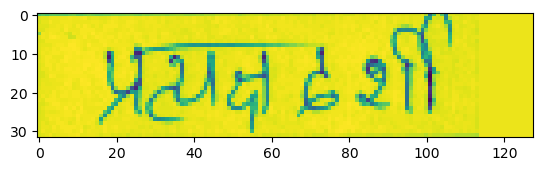

In [31]:
plt.imshow(curr_img)

In [32]:
curr_img = np.transpose(curr_img, (1, 0))
curr_img = np.expand_dims(curr_img, axis=-1)
curr_img = np.expand_dims(curr_img, axis=0)



In [33]:
curr_img.shape

(1, 128, 32, 1)

In [34]:
model.predict(curr_img)

([array([[48, 60,  3, 60, 23, 60, 23, 62, 23]])],
 [array([0.00018611], dtype=float32)])

In [38]:
print(charl[48])
print(charl[60])
print(charl[3])
print(charl[60])
print(charl[23])
print(charl[23])

र
ा
ं
ा
ग
ग


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.imshow(curr_img)

In [ ]:
print(charl[57])
print(charl[60])
print(charl[3])
print(charl[23])
print(charl[21])
print(charl[60])
print(charl[3])
print(charl[23])

In [ ]:
xt=test_datagen[0][0]
yt=test_datagen[0][1]

In [ ]:
predicts, _ = model.predict(x=xt,
                            ctc_decode=True,
                            verbose=1)

In [ ]:
len(predicts[0])

In [ ]:
predicts[1][0]

In [ ]:
def convert(predicts):
    a=[]
    b=[]
    for i in range(len(predicts)):
        b=[]
        for j in range(len(predicts[i][0])):
            b.append(charl[predicts[i][0][j]])
        a.append(b)
    return a

In [ ]:
def convert1(predicts):
    a=[]
    b=[]
    for i in range(len(predicts)):
        b=[]
        for j in range(len(predicts[i])):
            b.append(charl[int(predicts[i][j])])
        a.append(b)
    return a

In [ ]:
def trim(yt):
    yt1=[]
    for i in range(len(yt)):
        k=0
        for j in range(26,0,-1):
            if yt[i][j]!=0:
                yt1.append(yt[i][0:j+1])
                k=1
                break
        if k==0:
            yt1.append([0])
    return yt1

In [ ]:
yt1=trim(yt)

In [ ]:
len(yt1[0])

In [ ]:
len(yt[0])

In [ ]:
yt1[0][1]

In [ ]:
predicts1=convert(predicts)

In [ ]:
gt=convert1(yt1)

In [ ]:
from data import evaluation

In [ ]:

import string
import unicodedata
import editdistance
import numpy as np


def ocr_metrics(predicts, ground_truth, norm_accentuation=False, norm_punctuation=False):
    """Calculate Character Error Rate (CER), Word Error Rate (WER) and Sequence Error Rate (SER)"""

    if len(predicts) == 0 or len(ground_truth) == 0:
        return (1, 1, 1)

    cer, wer, ser = [], [], []

    for (pd, gt) in zip(predicts, ground_truth):
        '''pd, gt = pd.lower(), gt.lower()

        if norm_accentuation:
            pd = unicodedata.normalize("NFKD", pd).encode("ASCII", "ignore").decode("ASCII")
            gt = unicodedata.normalize("NFKD", gt).encode("ASCII", "ignore").decode("ASCII")

        if norm_punctuation:
            pd = pd.translate(str.maketrans("", "", string.punctuation))
            gt = gt.translate(str.maketrans("", "", string.punctuation))
	'''
        pd_cer, gt_cer = list(pd), list(gt)
        dist = editdistance.eval(pd_cer, gt_cer)
        cer.append(dist / (max(len(pd_cer), len(gt_cer))))
'''
        pd_wer, gt_wer = pd, gt
        dist = editdistance.eval(pd_wer, gt_wer)
        wer.append(dist / (max(len(pd_wer), len(gt_wer))))
        
        pd_ser, gt_ser = [pd], [gt]
        dist = editdistance.eval(pd_ser, gt_ser)
        ser.append(dist / (max(len(pd_ser), len(gt_ser))))
        '''
    metrics = [cer, wer]
    metrics = np.mean(metrics, axis=1)

    return metrics

In [ ]:
evaluate = ocr_metrics(predicts=predicts1,
                                  ground_truth=gt,)
 
print("Calculate Character Error Rate {} ".format(evaluate[0],))

In [ ]:
predicts1[0]

# charlist generation
